# Simple Optimization

## Introduction

The workflow of optimization is built on top of the SCF calculation. Basically, you adjust the structure based on the energy and forces calculated in the SCF calculation. 

The tutorial files associated in this example can by found here: [link to files](https://github.com/kimrojas/digital-alchemy/tree/main/book/files/qe_tutorial/02_01_simple_optimization)

## Input files

Similar to the SCF calculation, the input files for optimization are the same. The only difference is that you need to provide additional information about the optimization.

|File | Description|
|---|---|
|SLURM script | Submits the job to the cluster with required resources and environment |
|Python script | Controls the workflow |
|Structure file | Contains the atomic positions and lattice vectors of your system |

### Python file

In the python file you need to provide the additional following information:

```python
from ase.optimize import LBFGS

"... (other parts of the script)"

# Set the Maximum force threshold (fmax) parameter
fmax = 1e-4 * Rydberg / Bohr # ~0.0025 eV/Angstrom
# Initialize the optimizer
opt = LBFGS(atm, logfile="opt.log", trajectory="opt.traj", restart="opt.pckl")
# Run the optimization
opt.run(fmax=fmax)

# Save the final structure
write("relaxed.vasp", atm)
```

```{note} LBFGS/BFGS optimizer parameters
As you would have noticed, there are parameters set in the initialization of the optimizer. Here are some explanation:

- `logfile`
    : The file where the optimizer will write the optimization process per iteration.
- `trajectory`
    : The file where the optimizer will write the trajectory or structure of each iteration.
- `restart`
    : The file where the optimizer will save the state of the optimization. This is useful when you want to continue the optimization from a certain point.

I'll show a safe restart method in the next section. 
```

### Structure file

For this tutorial, we try to optimize HB sheet. The structure provided is already in a relaxed form and won't proceed with optimization if we use it. So, we artificially add small random displacements (rattle) to the atomic positions to make the structure not relaxed. 

```python
# Implemented already in the python file

# 1. INPUT STRUCTURE FILE
# 1.a - Read the input structure file
atm = read("pristine_vdw.vasp") # Read the input structure file
# 1.b - Apply artificial distortions
atm.rattle(stdev=0.0004, seed=0)  # -- Apply a small random displacement to the atoms
```

Here is a quick look on the unaltered structure and the rattled structure:

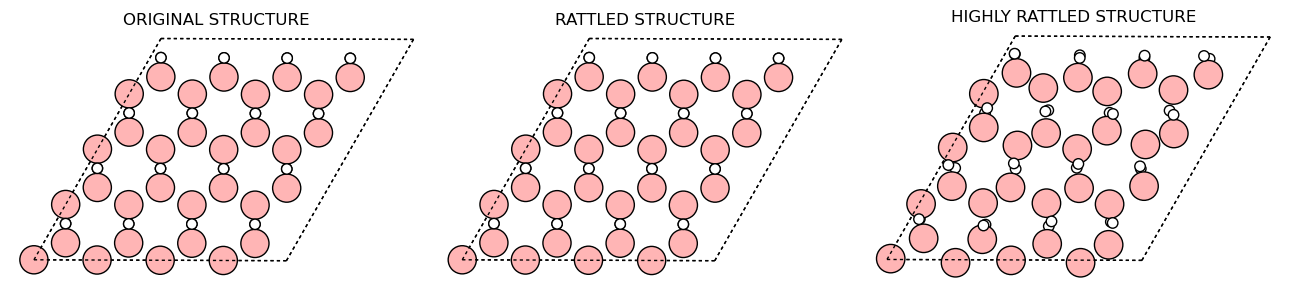

In [1]:
from ase.io import read
from pathlib import Path
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

cwd = Path.cwd()
bookdir = list(cwd.parents)[2]
filedir = bookdir / "files/qe_tutorial/02_01_simple_optimization"

structure_file = filedir / "pristine_vdw.vasp"

atm = read(structure_file)
atm_rattled = atm.copy()
atm_rattled.rattle(0.0004, seed=0)
atm_high_rattled = atm.copy()
atm_high_rattled.rattle(0.1, seed=0)

fig, ax = plt.subplots(1, 3, figsize=(13, 5))
plot_atoms(atm, ax[0], radii=0.8)
plot_atoms(atm_rattled, ax[1], radii=0.8)
plot_atoms(atm_high_rattled, ax[2], radii=0.8)

for iax in ax:
    iax.axis("off")
    iax.set_aspect("equal")
ax[0].set_title("ORIGINAL STRUCTURE");
ax[1].set_title("RATTLED STRUCTURE");
ax[2].set_title("HIGHLY RATTLED STRUCTURE");

fig.tight_layout()


As you can see, the Rattled structure (stdev=0.0004) that we use in the calculation is just slightly distored that it is hard to see the difference. For clarity, a highly rattled structure (stdev=0.1) is shown to better see the difference. We still use the rattle structure with stdev=0.0004 in the calculation because the highly rattled structure takes too much time to converge.


## Output file

We need 3 files to analyze the relaxation carefully.

- `opt.log` - Contains the optimization process per iteration. We need to check if the computed force is below the threshold.
- `opt.traj` - Contains the trajectory of the optimization. We need to visualize the trajectory to see the final structure and the "path" travelled.
- `relaxed.vasp` - Contains the final structure of the optimization. For easy checking in the future, we save the final structure.
